In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#import models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate
from sklearn.model_selection import RepeatedKFold

from sklearn import metrics

In [2]:
datas = '/Users/pkrok/OneDrive/Python/Giannakopoulos/MyData.xlsx'

In [3]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])
# df = df.dropna()
# df[df.gas == 'propylene']['logD'].max()
df[df.gas == 'H2']['logD'].count()

61

In [4]:
# df = df[df.gas != 'butane']
# df = df[df.gas != 'ch4']
# df = df[df.type != 'Co-Br-ZIF-7-8']
# df.type.unique

# Keep only the columns I need

In [5]:
# df2=df[[ 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'gas', 'apertureAtom_e', 'ionicRad']]
df2=df[[ 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'ionicRad', 
       'Μ-N_lff', 'Μ-N_kFF', 'ionicRad', 'MetalCharge',
       'apertureAtom_σ', 'apertureAtom_e', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',
       'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
       'func3_charge',]]
df2.head()

,aperture,size - van der Waals (Å),mass,ascentricF,logD,size - kinetic diameter (Å),ionicRad,Μ-N_lff,Μ-N_kFF,ionicRad,MetalCharge,apertureAtom_σ,apertureAtom_e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge
0,3.92,2.66,4.002,-0.390,-7.221849,2.60,92,2.257,45354.6,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
1,3.92,2.76,2.010,-0.217,-7.301030,2.89,92,2.257,45354.6,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
2,3.92,2.94,31.999,0.022,-8.000000,3.46,92,2.257,45354.6,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
3,3.92,3.24,44.010,0.225,-8.397940,3.30,92,2.257,45354.6,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
4,3.92,3.13,28.000,0.037,-8.301030,3.64,92,2.257,45354.6,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001


# Get a first correlation of ionic radius with aperture

In [6]:
df2[['aperture','logD']].corr(method="spearman")

,aperture,logD
aperture,1.00000,0.59506
logD,0.59506,1.00000


In [7]:
df2=df2.rename(columns={'size - van der Waals (Å)':'diameter', 'size - kinetic diameter (Å)':'kdiameter', 'apertureAtom_e':'e' })

In [8]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)
df2

,aperture,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,ionicRad,MetalCharge,apertureAtom_σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge
0,3.92,2.66,4.002,-0.390,-7.221849,2.60,92,2.257,45354.60,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.000,81.000,81.000,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
1,3.92,2.76,2.010,-0.217,-7.301030,2.89,92,2.257,45354.60,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.000,81.000,81.000,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
2,3.92,2.94,31.999,0.022,-8.000000,3.46,92,2.257,45354.60,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.000,81.000,81.000,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
3,3.92,3.24,44.010,0.225,-8.397940,3.30,92,2.257,45354.60,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.000,81.000,81.000,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
4,3.92,3.13,28.000,0.037,-8.301030,3.64,92,2.257,45354.60,92,1.1901,0.25,0.0627,4.438,4.438,4.438,81.000,81.000,81.000,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,2.95,2.76,2.010,-0.217,-7.455932,2.89,71,2.139,38994.88,71,1.9871,0.34,1.2552,6.410,6.410,6.410,134.906,134.906,134.906,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710
591,2.95,2.94,31.999,0.022,-9.180456,3.46,71,2.139,38994.88,71,1.9871,0.34,1.2552,6.410,6.410,6.410,134.906,134.906,134.906,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710
592,2.95,3.24,44.010,0.225,-9.096910,3.30,71,2.139,38994.88,71,1.9871,0.34,1.2552,6.410,6.410,6.410,134.906,134.906,134.906,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710
593,2.95,3.13,28.000,0.037,-9.638272,3.64,71,2.139,38994.88,71,1.9871,0.34,1.2552,6.410,6.410,6.410,134.906,134.906,134.906,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710


# Use only van der Waals

In [9]:
# df2['ratio']=1/(df2['aperture2']-df2['aperture'])/df2['diameter']
# df2[['ratio','logD']].corr(method="spearman")

In [10]:
x = np.asanyarray(df2[['aperture', 'diameter']])
y = np.asanyarray(df2[['logD']])

x1 = (df2[['aperture', 'diameter']])
y1 = (df2[['logD']])


# x = np.asanyarray(df2[['aperture', 'diameter','mass', 'ascentricF', 'kdiameter', 'ionicRad', 
#        'Μ-N_lff', 'Μ-N_kFF', 'ionicRad', 'MetalCharge',
#        'apertureAtom_σ', 'e', 'linker_length1', 'linker_length2',
#        'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
#        'func1_length', 'func2_length', 'func3_length', 'func1_mass',
#        'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
#        'func3_charge']])
# y = np.asanyarray(df2[['logD']])

# x1 = (df2[['aperture', 'diameter','mass', 'ascentricF', 'kdiameter', 'ionicRad', 
#        'Μ-N_lff', 'Μ-N_kFF', 'ionicRad', 'MetalCharge',
#        'apertureAtom_σ', 'e', 'linker_length1', 'linker_length2',
#        'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
#        'func1_length', 'func2_length', 'func3_length', 'func1_mass',
#        'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
#        'func3_charge']])
# y1 = (df2[['logD']])

In [11]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=5,random_state=1)
NNregr = MLPRegressor(hidden_layer_sizes=(60, 10, 20), solver='lbfgs', random_state=1, max_iter=6000)
RF = RandomForestRegressor(max_depth=5, random_state=1)

# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF = list(), list(), list(), list(), list()
kfold = KFold(n_splits=40, shuffle=True, random_state=5)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # fit model
    tree.fit(train_X, train_y)
    NNregr.fit(train_X, train_y.ravel())
    regr.fit(train_X, train_y)
    RF.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_tree = tree.predict(test_X)
    yhat_regr = regr.predict(test_X)
    yhat_NNregr = NNregr.predict(test_X)
    yhat_RF = RF.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_tree.extend(yhat_tree)
    data_yhat_regr.extend(yhat_regr)
    data_yhat_NN.extend(yhat_NNregr)
    data_yhat_RF.extend(yhat_RF)
    
# evaluate the model

R2_DT = (metrics.r2_score(data_y, data_yhat_tree))
Med_ABS_er_DT = (metrics.median_absolute_error(data_y, data_yhat_tree))
Max_error_DT = (metrics.max_error(data_y, data_yhat_tree))
EV_DT = (metrics.explained_variance_score(data_y, data_yhat_tree))
Mean_abs_perc_error_DT = (metrics.mean_absolute_percentage_error(data_y, data_yhat_tree))
MSE_DT = (metrics.mean_squared_error(data_y, data_yhat_tree))

R2_regr = (metrics.r2_score(data_y, data_yhat_regr))
Med_ABS_er_regr = (metrics.median_absolute_error(data_y, data_yhat_regr))
Max_error_regr = (metrics.max_error(data_y, data_yhat_regr))
EV_regr = (metrics.explained_variance_score(data_y, data_yhat_regr))
Mean_abs_perc_error_regr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_regr))
MSE_regr = (metrics.mean_squared_error(data_y, data_yhat_regr))

R2_NN = (metrics.r2_score(data_y, data_yhat_NN))
Med_ABS_er_NN = (metrics.median_absolute_error(data_y, data_yhat_NN))
Max_error_NN = (metrics.max_error(data_y, data_yhat_NN))
EV_NN = (metrics.explained_variance_score(data_y, data_yhat_NN))
Mean_abs_perc_error_NN = (metrics.mean_absolute_percentage_error(data_y, data_yhat_NN))
MSE_NN = (metrics.mean_squared_error(data_y, data_yhat_NN))

R2_RF = (metrics.r2_score(data_y, data_yhat_RF))
Med_ABS_er_RF = (metrics.median_absolute_error(data_y, data_yhat_RF))
Max_error_RF = (metrics.max_error(data_y, data_yhat_RF))
EV_RF = (metrics.explained_variance_score(data_y, data_yhat_RF))
Mean_abs_perc_error_RF = (metrics.mean_absolute_percentage_error(data_y, data_yhat_RF))
MSE_RF = (metrics.mean_squared_error(data_y, data_yhat_RF))


head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [["Decision tree", R2_DT, Med_ABS_er_DT, Max_error_DT, EV_DT, Mean_abs_perc_error_DT, MSE_DT],
           ["Regression", R2_regr, Med_ABS_er_regr, Max_error_regr, EV_regr, Mean_abs_perc_error_regr, MSE_regr],
           ["Neural Network", R2_NN, Med_ABS_er_NN, Max_error_NN, EV_NN, Mean_abs_perc_error_NN, MSE_NN],
           ["Random Forest", R2_RF, Med_ABS_er_RF, Max_error_RF, EV_RF, Mean_abs_perc_error_RF, MSE_RF]]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

╒════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤════════╕
│ Model          │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │    MSE │
╞════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪════════╡
│ Decision tree  │ 0.902 │           0.681 │      10.458 │                0.902 │                 0.081 │  3.527 │
├────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼────────┤
│ Regression     │ 0.706 │           1.856 │      22.109 │                0.706 │                 0.187 │ 10.607 │
├────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼────────┤
│ Neural Network │ 0.849 │           0.750 │      14.261 │                0.849 │                 0.095 │  5.447 │
├────────────────┼───────┼─────────────────┼─────────────┼──────────────────────

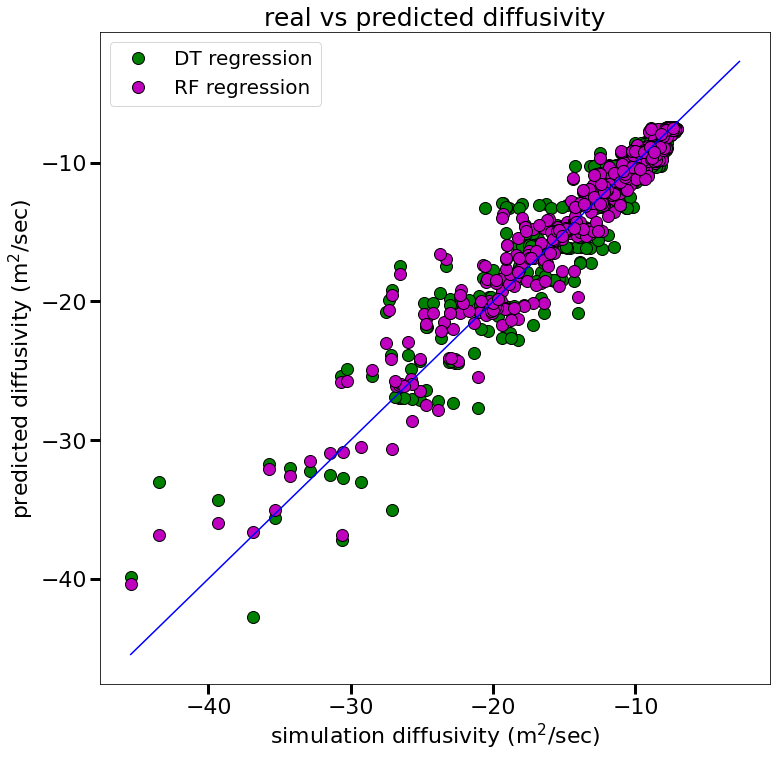

In [16]:
# plt.plot(data_y, data_yhat_regr, 'o', label='regression', c='r', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_tree, 'o', label='DT regression', c='g', markersize='12', linewidth=3, markeredgecolor='k')
# plt.plot(data_y, data_yhat_NN, 'o', label='NN regression', c='b', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_RF, 'o', label='RF regression', c='m', markersize='12', linewidth=3, markeredgecolor='k')

plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity ($\mathregular{m^{2}}$/sec)', fontsize=22)
plt.ylabel('predicted diffusivity ($\mathregular{m^{2}}$/sec)',fontsize=22)
plt.legend(loc='upper left', fontsize=20)

p1 = max(max(data_y), max(data_yhat_regr))
p2 = min(min(data_y), min(data_yhat_regr))
plt.plot([p1, p2], [p1, p2],'b-' )

# plt.ylim(1.5, 5)
# plt.xlim(1.5, 5)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (12,12)

plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

plt.show()

# Add kinetic diameterin my features

In [17]:
x = np.asanyarray(df2[['aperture', 'diameter', 'mass', 'kdiameter', 'ascentricF']])
y = np.asanyarray(df2[['logD']])

x1 = (df2[['aperture', 'diameter', 'mass', 'kdiameter', 'ascentricF']])
y1 = (df2[['logD']])

In [18]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=5,random_state=1)
NNregr = MLPRegressor(hidden_layer_sizes=(40, 20, 20, 30, 10), solver='lbfgs', random_state=1, max_iter=5000)
RF = RandomForestRegressor(max_depth=5, random_state=1)

# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF = list(), list(), list(), list(), list()
kfold = KFold(n_splits=40, shuffle=True, random_state=5)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # fit model
    tree.fit(train_X, train_y)
    NNregr.fit(train_X, train_y.ravel())
    regr.fit(train_X, train_y)
    RF.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_tree = tree.predict(test_X)
    yhat_regr = regr.predict(test_X)
    yhat_NNregr = NNregr.predict(test_X)
    yhat_RF = RF.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_tree.extend(yhat_tree)
    data_yhat_regr.extend(yhat_regr)
    data_yhat_NN.extend(yhat_NNregr)
    data_yhat_RF.extend(yhat_RF)
    
# evaluate the model

R2_DT = (metrics.r2_score(data_y, data_yhat_tree))
Med_ABS_er_DT = (metrics.median_absolute_error(data_y, data_yhat_tree))
Max_error_DT = (metrics.max_error(data_y, data_yhat_tree))
EV_DT = (metrics.explained_variance_score(data_y, data_yhat_tree))
Mean_abs_perc_error_DT = (metrics.mean_absolute_percentage_error(data_y, data_yhat_tree))
MSE_DT = (metrics.mean_squared_error(data_y, data_yhat_tree))

R2_regr = (metrics.r2_score(data_y, data_yhat_regr))
Med_ABS_er_regr = (metrics.median_absolute_error(data_y, data_yhat_regr))
Max_error_regr = (metrics.max_error(data_y, data_yhat_regr))
EV_regr = (metrics.explained_variance_score(data_y, data_yhat_regr))
Mean_abs_perc_error_regr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_regr))
MSE_regr = (metrics.mean_squared_error(data_y, data_yhat_regr))

R2_NN = (metrics.r2_score(data_y, data_yhat_NN))
Med_ABS_er_NN = (metrics.median_absolute_error(data_y, data_yhat_NN))
Max_error_NN = (metrics.max_error(data_y, data_yhat_NN))
EV_NN = (metrics.explained_variance_score(data_y, data_yhat_NN))
Mean_abs_perc_error_NN = (metrics.mean_absolute_percentage_error(data_y, data_yhat_NN))
MSE_NN = (metrics.mean_squared_error(data_y, data_yhat_NN))

R2_RF = (metrics.r2_score(data_y, data_yhat_RF))
Med_ABS_er_RF = (metrics.median_absolute_error(data_y, data_yhat_RF))
Max_error_RF = (metrics.max_error(data_y, data_yhat_RF))
EV_RF = (metrics.explained_variance_score(data_y, data_yhat_RF))
Mean_abs_perc_error_RF = (metrics.mean_absolute_percentage_error(data_y, data_yhat_RF))
MSE_RF = (metrics.mean_squared_error(data_y, data_yhat_RF))


head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [["Decision tree", R2_DT, Med_ABS_er_DT, Max_error_DT, EV_DT, Mean_abs_perc_error_DT, MSE_DT],
           ["Regression", R2_regr, Med_ABS_er_regr, Max_error_regr, EV_regr, Mean_abs_perc_error_regr, MSE_regr],
           ["Neural Network", R2_NN, Med_ABS_er_NN, Max_error_NN, EV_NN, Mean_abs_perc_error_NN, MSE_NN],
           ["Random Forest", R2_RF, Med_ABS_er_RF, Max_error_RF, EV_RF, Mean_abs_perc_error_RF, MSE_RF]]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

C:\Users\pkrok\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


╒════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤════════╕
│ Model          │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │    MSE │
╞════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪════════╡
│ Decision tree  │ 0.905 │           0.623 │      10.458 │                0.905 │                 0.079 │  3.410 │
├────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼────────┤
│ Regression     │ 0.716 │           1.973 │      22.338 │                0.716 │                 0.185 │ 10.229 │
├────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼────────┤
│ Neural Network │ 0.870 │           0.609 │      17.485 │                0.870 │                 0.079 │  4.699 │
├────────────────┼───────┼─────────────────┼─────────────┼──────────────────────

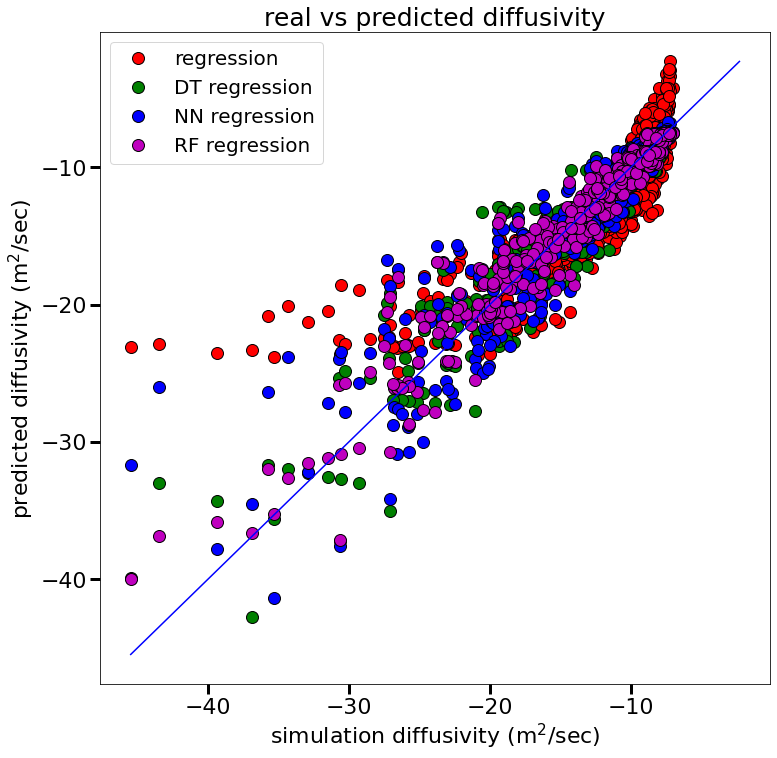

In [20]:
plt.plot(data_y, data_yhat_regr, 'o', label='regression', c='r', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_tree, 'o', label='DT regression', c='g', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_NN, 'o', label='NN regression', c='b', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_RF, 'o', label='RF regression', c='m', markersize='12', linewidth=3, markeredgecolor='k')

plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity ($\mathregular{m^{2}}$/sec)', fontsize=22)
plt.ylabel('predicted diffusivity ($\mathregular{m^{2}}$/sec)',fontsize=22)
plt.legend(loc='upper left', fontsize=20)

p1 = max(max(data_y), max(data_yhat_regr))
p2 = min(min(data_y), min(data_yhat_regr))
plt.plot([p1, p2], [p1, p2],'b-' )

# plt.ylim(1.5, 5)
# plt.xlim(1.5, 5)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (12,12)

plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

plt.show()

# Add linker and functional info

In [22]:
# x = np.asanyarray(df2[['aperture', 'apertureAtom_σ', 'diameter', 'kdiameter', 'ascentricF', 'ionicRad','mass', 'linker_length1', 'linker_length2',
#        'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
#        'func1_length', 'func2_length', 'func3_length', 'func1_mass',
#        'func2_mass', 'func3_mass','ionicRad','e','Μ-N_lff', 'Μ-N_kFF', 'ionicRad', 'MetalCharge','func1_charge', 'func2_charge',
#        'func3_charge' ]])
# y = np.asanyarray(df2[['logD']])

x = np.asanyarray(df2[['aperture', 'apertureAtom_σ', 'diameter', 'kdiameter', 'ascentricF', 'ionicRad','mass', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',
       'func2_mass', 'func3_mass','ionicRad','e' ]])
y = np.asanyarray(df2[['logD']])

In [28]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=6,random_state=1)
# NNregr = MLPRegressor(hidden_layer_sizes=(30, 10, 20), solver='lbfgs', random_state=1, max_iter=4000)
RF = RandomForestRegressor(max_depth=6, random_state=1)
GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=5, random_state=0,loss='squared_error')
XGBR = XGBRegressor(n_estimators=200, max_depth=3, eta=0.2, subsample=0.8, colsample_bytree=0.8)

# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF, data_yhat_GBR, data_yhat_XGBR = list(), list(), list(), list(), list(), list(), list()
kfold = KFold(n_splits=10, shuffle=True, random_state=500)
# enumerate splits
for train_ix, test_ix in kfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # fit model
    tree.fit(train_X, train_y)
    # NNregr.fit(train_X, train_y.ravel())
    regr.fit(train_X, train_y)
    RF.fit(train_X, train_y.ravel())
    GBR.fit(train_X, train_y.ravel())
    XGBR.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_tree = tree.predict(test_X)
    yhat_regr = regr.predict(test_X)
    # yhat_NNregr = NNregr.predict(test_X)
    yhat_RF = RF.predict(test_X)
    yhat_GBR = GBR.predict(test_X)
    yhat_XGBR = XGBR.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_tree.extend(yhat_tree)
    data_yhat_regr.extend(yhat_regr)
    # data_yhat_NN.extend(yhat_NNregr)
    data_yhat_RF.extend(yhat_RF)
    data_yhat_GBR.extend(yhat_GBR)
    data_yhat_XGBR.extend(yhat_XGBR)
# evaluate the model

R2_DT = (metrics.r2_score(data_y, data_yhat_tree))
Med_ABS_er_DT = (metrics.median_absolute_error(data_y, data_yhat_tree))
Max_error_DT = (metrics.max_error(data_y, data_yhat_tree))
EV_DT = (metrics.explained_variance_score(data_y, data_yhat_tree))
Mean_abs_perc_error_DT = (metrics.mean_absolute_percentage_error(data_y, data_yhat_tree))
MSE_DT = (metrics.mean_squared_error(data_y, data_yhat_tree))

R2_regr = (metrics.r2_score(data_y, data_yhat_regr))
Med_ABS_er_regr = (metrics.median_absolute_error(data_y, data_yhat_regr))
Max_error_regr = (metrics.max_error(data_y, data_yhat_regr))
EV_regr = (metrics.explained_variance_score(data_y, data_yhat_regr))
Mean_abs_perc_error_regr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_regr))
MSE_regr = (metrics.mean_squared_error(data_y, data_yhat_regr))

# R2_NN = (metrics.r2_score(data_y, data_yhat_NN))
# Med_ABS_er_NN = (metrics.median_absolute_error(data_y, data_yhat_NN))
# Max_error_NN = (metrics.max_error(data_y, data_yhat_NN))
# EV_NN = (metrics.explained_variance_score(data_y, data_yhat_NN))
# Mean_abs_perc_error_NN = (metrics.mean_absolute_percentage_error(data_y, data_yhat_NN))
# MSE_NN = (metrics.mean_squared_error(data_y, data_yhat_NN))

R2_RF = (metrics.r2_score(data_y, data_yhat_RF))
Med_ABS_er_RF = (metrics.median_absolute_error(data_y, data_yhat_RF))
Max_error_RF = (metrics.max_error(data_y, data_yhat_RF))
EV_RF = (metrics.explained_variance_score(data_y, data_yhat_RF))
Mean_abs_perc_error_RF = (metrics.mean_absolute_percentage_error(data_y, data_yhat_RF))
MSE_RF = (metrics.mean_squared_error(data_y, data_yhat_RF))

R2_GBR = (metrics.r2_score(data_y, data_yhat_GBR))
Med_ABS_er_GBR = (metrics.median_absolute_error(data_y, data_yhat_GBR))
Max_error_GBR = (metrics.max_error(data_y, data_yhat_GBR))
EV_GBR = (metrics.explained_variance_score(data_y, data_yhat_GBR))
Mean_abs_perc_error_GBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_GBR))
MSE_GBR = (metrics.mean_squared_error(data_y, data_yhat_GBR))

R2_XGBR = (metrics.r2_score(data_y, data_yhat_XGBR))
Med_ABS_er_XGBR = (metrics.median_absolute_error(data_y, data_yhat_XGBR))
Max_error_XGBR = (metrics.max_error(data_y, data_yhat_XGBR))
EV_XGBR = (metrics.explained_variance_score(data_y, data_yhat_XGBR))
Mean_abs_perc_error_XGBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_XGBR))
MSE_XGBR = (metrics.mean_squared_error(data_y, data_yhat_XGBR))


head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [["Regression", R2_regr, Med_ABS_er_regr, Max_error_regr, EV_regr, Mean_abs_perc_error_regr, MSE_regr],
           ["Decision tree", R2_DT, Med_ABS_er_DT, Max_error_DT, EV_DT, Mean_abs_perc_error_DT, MSE_DT],
           ["Random Forest", R2_RF, Med_ABS_er_RF, Max_error_RF, EV_RF, Mean_abs_perc_error_RF, MSE_RF],
           ["Gradient Tree Boosting", R2_GBR, Med_ABS_er_GBR, Max_error_GBR, EV_GBR, Mean_abs_perc_error_GBR, MSE_GBR],
           ["Extreme Gradient Boosting", R2_XGBR, Med_ABS_er_XGBR, Max_error_XGBR, EV_XGBR, Mean_abs_perc_error_XGBR, MSE_XGBR]]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

╒═══════════════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤═══════╕
│ Model                     │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │   MSE │
╞═══════════════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪═══════╡
│ Regression                │ 0.757 │           1.759 │      19.181 │                0.757 │                 0.182 │ 8.751 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Decision tree             │ 0.946 │           0.518 │      10.589 │                0.946 │                 0.063 │ 1.960 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Random Forest             │ 0.965 │           0.379 │       6.743 │                0.965 │                 0.048 │ 1.244 │


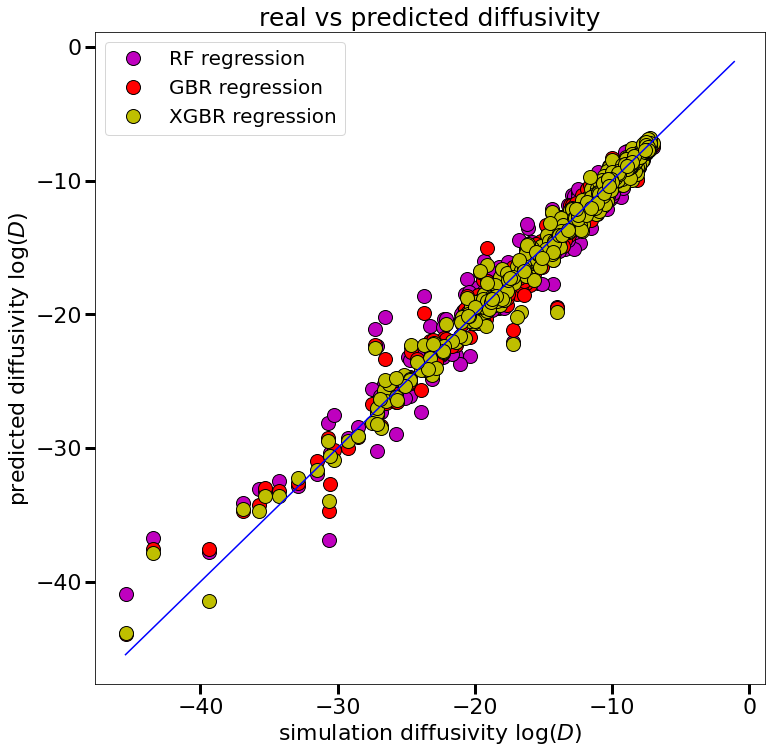

In [29]:
# plt.plot(data_y, data_yhat_regr, 'o', label='regression', c='r', markersize='12', linewidth=3, markeredgecolor='k')
# plt.plot(data_y, data_yhat_tree, 'o', label='DT regression', c='g', markersize='14', linewidth=3, markeredgecolor='k')
# plt.plot(data_y, data_yhat_NN, 'o', label='NN regression', c='b', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_RF, 'o', label='RF regression', c='m', markersize='14', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_GBR, 'o', label='GBR regression', c='r', markersize='14', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='XGBR regression', c='y', markersize='14', linewidth=3, markeredgecolor='k')

plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity log($D$)', fontsize=22)
plt.ylabel('predicted diffusivity log($D$)',fontsize=22)
plt.legend(loc='upper left', fontsize=20)

p1 = max(max(data_y), max(data_yhat_regr))
p2 = min(min(data_y), min(data_yhat_regr))
plt.plot([p1, p2], [p1, p2],'b-' )

# plt.ylim(1.5, 5)
# plt.xlim(1.5, 5)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (12,12)

plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

plt.savefig('diffusivity_DT_RF_GBR.png', bbox_inches='tight')
plt.show()

# With repeated K-Fold

In [25]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=7,random_state=1)
# NNregr = MLPRegressor(hidden_layer_sizes=(30, 10, 20), solver='lbfgs', random_state=1, max_iter=4000)
RF = RandomForestRegressor(max_depth=7, random_state=1)
GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=5, random_state=0,loss='squared_error')
XGBR = XGBRegressor(n_estimators=200, max_depth=3, eta=0.2, subsample=0.8, colsample_bytree=0.8)

# k-fold cross validation
data_y, data_yhat_tree, data_yhat_NN, data_yhat_regr, data_yhat_RF, data_yhat_GBR, data_yhat_XGBR = list(), list(), list(), list(), list(), list(), list()
Repfold = RepeatedKFold(n_splits=40, n_repeats=10, random_state=2652124)
# enumerate splits
for train_ix, test_ix in Repfold.split(x):
    # get data
    train_X, test_X = x[train_ix], x[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # fit model
    tree.fit(train_X, train_y)
    # NNregr.fit(train_X, train_y.ravel())
    regr.fit(train_X, train_y)
    RF.fit(train_X, train_y.ravel())
    GBR.fit(train_X, train_y.ravel())
    XGBR.fit(train_X, train_y.ravel())
    
    # make predictions
    yhat_tree = tree.predict(test_X)
    yhat_regr = regr.predict(test_X)
    # yhat_NNregr = NNregr.predict(test_X)
    yhat_RF = RF.predict(test_X)
    yhat_GBR = GBR.predict(test_X)
    yhat_XGBR = XGBR.predict(test_X)

    # store
    data_y.extend(test_y)
    data_yhat_tree.extend(yhat_tree)
    data_yhat_regr.extend(yhat_regr)
    # data_yhat_NN.extend(yhat_NNregr)
    data_yhat_RF.extend(yhat_RF)
    data_yhat_GBR.extend(yhat_GBR)
    data_yhat_XGBR.extend(yhat_XGBR)
# evaluate the model

R2_DT = (metrics.r2_score(data_y, data_yhat_tree))
Med_ABS_er_DT = (metrics.median_absolute_error(data_y, data_yhat_tree))
Max_error_DT = (metrics.max_error(data_y, data_yhat_tree))
EV_DT = (metrics.explained_variance_score(data_y, data_yhat_tree))
Mean_abs_perc_error_DT = (metrics.mean_absolute_percentage_error(data_y, data_yhat_tree))
MSE_DT = (metrics.mean_squared_error(data_y, data_yhat_tree))

R2_regr = (metrics.r2_score(data_y, data_yhat_regr))
Med_ABS_er_regr = (metrics.median_absolute_error(data_y, data_yhat_regr))
Max_error_regr = (metrics.max_error(data_y, data_yhat_regr))
EV_regr = (metrics.explained_variance_score(data_y, data_yhat_regr))
Mean_abs_perc_error_regr = (metrics.mean_absolute_percentage_error(data_y, data_yhat_regr))
MSE_regr = (metrics.mean_squared_error(data_y, data_yhat_regr))

# R2_NN = (metrics.r2_score(data_y, data_yhat_NN))
# Med_ABS_er_NN = (metrics.median_absolute_error(data_y, data_yhat_NN))
# Max_error_NN = (metrics.max_error(data_y, data_yhat_NN))
# EV_NN = (metrics.explained_variance_score(data_y, data_yhat_NN))
# Mean_abs_perc_error_NN = (metrics.mean_absolute_percentage_error(data_y, data_yhat_NN))
# MSE_NN = (metrics.mean_squared_error(data_y, data_yhat_NN))

R2_RF = (metrics.r2_score(data_y, data_yhat_RF))
Med_ABS_er_RF = (metrics.median_absolute_error(data_y, data_yhat_RF))
Max_error_RF = (metrics.max_error(data_y, data_yhat_RF))
EV_RF = (metrics.explained_variance_score(data_y, data_yhat_RF))
Mean_abs_perc_error_RF = (metrics.mean_absolute_percentage_error(data_y, data_yhat_RF))
MSE_RF = (metrics.mean_squared_error(data_y, data_yhat_RF))

R2_GBR = (metrics.r2_score(data_y, data_yhat_GBR))
Med_ABS_er_GBR = (metrics.median_absolute_error(data_y, data_yhat_GBR))
Max_error_GBR = (metrics.max_error(data_y, data_yhat_GBR))
EV_GBR = (metrics.explained_variance_score(data_y, data_yhat_GBR))
Mean_abs_perc_error_GBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_GBR))
MSE_GBR = (metrics.mean_squared_error(data_y, data_yhat_GBR))

R2_XGBR = (metrics.r2_score(data_y, data_yhat_XGBR))
Med_ABS_er_XGBR = (metrics.median_absolute_error(data_y, data_yhat_XGBR))
Max_error_XGBR = (metrics.max_error(data_y, data_yhat_XGBR))
EV_XGBR = (metrics.explained_variance_score(data_y, data_yhat_XGBR))
Mean_abs_perc_error_XGBR = (metrics.mean_absolute_percentage_error(data_y, data_yhat_XGBR))
MSE_XGBR = (metrics.mean_squared_error(data_y, data_yhat_XGBR))


head = ["Model", "R2", "Med ABS error", "Max error", "explained variance", "Mean ABS perc error", "MSE" ]

results = [["Regression", R2_regr, Med_ABS_er_regr, Max_error_regr, EV_regr, Mean_abs_perc_error_regr, MSE_regr],
           ["Decision tree", R2_DT, Med_ABS_er_DT, Max_error_DT, EV_DT, Mean_abs_perc_error_DT, MSE_DT],
           ["Random Forest", R2_RF, Med_ABS_er_RF, Max_error_RF, EV_RF, Mean_abs_perc_error_RF, MSE_RF],
           ["Gradient Tree Boosting", R2_GBR, Med_ABS_er_GBR, Max_error_GBR, EV_GBR, Mean_abs_perc_error_GBR, MSE_GBR],
           ["Extreme Gradient Boosting", R2_XGBR, Med_ABS_er_XGBR, Max_error_XGBR, EV_XGBR, Mean_abs_perc_error_XGBR, MSE_XGBR]]

print(tabulate(results, headers = head, tablefmt = "fancy_grid", floatfmt=".3f"))

╒═══════════════════════════╤═══════╤═════════════════╤═════════════╤══════════════════════╤═══════════════════════╤═══════╕
│ Model                     │    R2 │   Med ABS error │   Max error │   explained variance │   Mean ABS perc error │   MSE │
╞═══════════════════════════╪═══════╪═════════════════╪═════════════╪══════════════════════╪═══════════════════════╪═══════╡
│ Regression                │ 0.760 │           1.759 │      19.877 │                0.760 │                 0.180 │ 8.651 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Decision tree             │ 0.955 │           0.410 │       9.728 │                0.955 │                 0.055 │ 1.613 │
├───────────────────────────┼───────┼─────────────────┼─────────────┼──────────────────────┼───────────────────────┼───────┤
│ Random Forest             │ 0.973 │           0.330 │       7.922 │                0.973 │                 0.042 │ 0.969 │


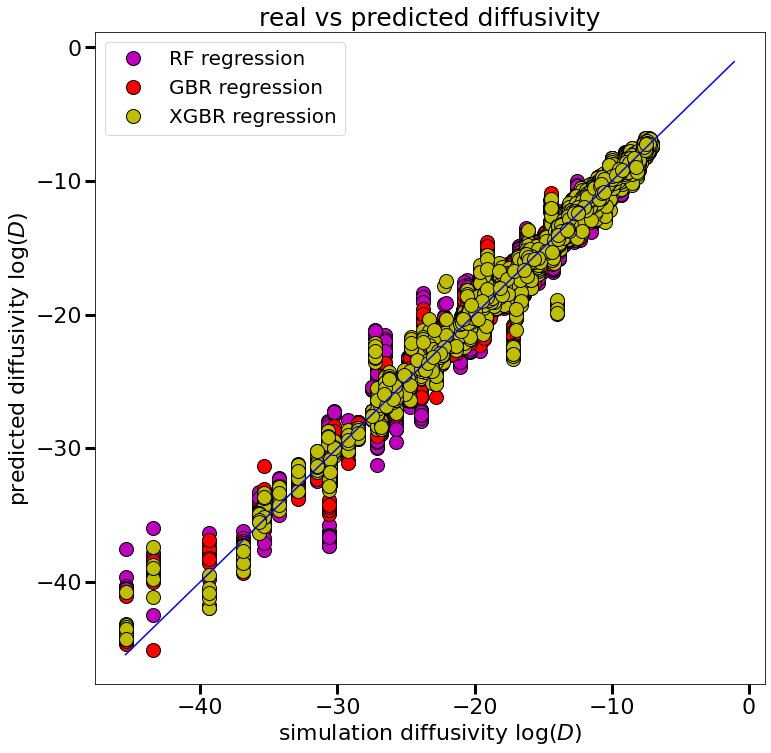

In [26]:
# plt.plot(data_y, data_yhat_regr, 'o', label='regression', c='r', markersize='12', linewidth=3, markeredgecolor='k')
# plt.plot(data_y, data_yhat_tree, 'o', label='DT regression', c='g', markersize='14', linewidth=3, markeredgecolor='k')
# plt.plot(data_y, data_yhat_NN, 'o', label='NN regression', c='b', markersize='12', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_RF, 'o', label='RF regression', c='m', markersize='14', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_GBR, 'o', label='GBR regression', c='r', markersize='14', linewidth=3, markeredgecolor='k')
plt.plot(data_y, data_yhat_XGBR, 'o', label='XGBR regression', c='y', markersize='14', linewidth=3, markeredgecolor='k')

plt.title ('real vs predicted diffusivity',fontsize=25)
plt.xlabel('simulation diffusivity log($D$)', fontsize=22)
plt.ylabel('predicted diffusivity log($D$)',fontsize=22)
plt.legend(loc='upper left', fontsize=20)

p1 = max(max(data_y), max(data_yhat_regr))
p2 = min(min(data_y), min(data_yhat_regr))
plt.plot([p1, p2], [p1, p2],'b-' )

# plt.ylim(1.5, 5)
# plt.xlim(1.5, 5)

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='r')
plt.rcParams["figure.figsize"] = (12,12)

plt.yticks(fontsize=22)
plt.xticks(fontsize=22)

plt.savefig('diffusivity_DT_RF_GBR.png', bbox_inches='tight')
plt.show()

In [30]:
import mlxtend
from mlxtend.evaluate import paired_ttest_5x2cv

In [31]:
tree=DecisionTreeRegressor(random_state=None, max_depth=6)
rf = RandomForestRegressor(max_depth=6, random_state=None)
GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=5, random_state=0,loss='squared_error')
XGBR = XGBRegressor(n_estimators=200, max_depth=3, eta=0.2, subsample=0.8, colsample_bytree=0.8)

In [32]:
t, p = paired_ttest_5x2cv(estimator1=GBR,
                          estimator2=rf,
                          X=x, y=y.ravel(),
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 5.366
p value: 0.003


In [33]:
from mlxtend.evaluate import paired_ttest_kfold_cv

In [34]:
t, p = paired_ttest_kfold_cv(estimator1=GBR,
                          estimator2=rf,
                          X=x, y=y.ravel(),
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 2.402
p value: 0.040


In [35]:
t, p = paired_ttest_5x2cv(estimator1=XGBR,
                          estimator2=RF,
                          X=x, y=y.ravel(),
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 6.804
p value: 0.001


In [ ]:
# colTran=df2['gas']
# df_with_dummies = pd.get_dummies( df2['gas'] )

In [ ]:
df_with_dummies